In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

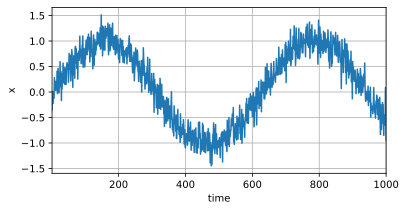

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
# tao意思是关联前面四项
tau = 4  

# 行数，列数。初始化一个特征矩阵用来存放每一个标签对应的前面四项
features = torch.zeros((T - tau, tau))

# 对矩阵进行赋值
for i in range(tau):
    features[:, i] = x[i: T - tau + i]  

# 制造标签为第5项到第100项
labels = x[tau:].reshape((-1, 1)) 

In [4]:
batch_size, n_train = 16, 600

# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True) 
# 制作训练集,注意这里可以打乱训练集的原因是标签和四个特征已经一一配对

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)  # 给每个线性层使用 Xavier 均匀分布初始化权重（这是深度学习中比较稳定的初始化方式）

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights) 
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')  # 不自动求平均，方便后面求和

In [6]:
# 定义训练函数
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)  # 使用 Adam 优化器（通常比 SGD 收敛更快）
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()  # 对所有样本loss求和再向前传播
            trainer.step()  # 更新参数
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01) # 开始训练

epoch 1, loss: 0.069655
epoch 2, loss: 0.055001
epoch 3, loss: 0.052818
epoch 4, loss: 0.047186
epoch 5, loss: 0.045844


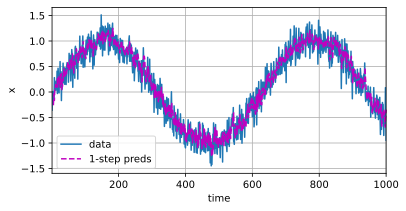

In [7]:
onestep_preds = net(features)  # 把前面准备好的所有特征 [x₀,x₁,x₂,x₃], [x₁,x₂,x₃,x₄], ... 喂进模型
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))  # 将真实时间序列 x 和预测序列 onestep_preds 画到一张图上

In [8]:
multistep_preds = torch.zeros(T)  # 创建一个预测序列张量 multistep_preds，长度等于原始时间序列长度
multistep_preds[: n_train + tau] = x[: n_train + tau]  # 将前 604 个数据点用真实值填充（用于做初始预测），x为特征
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))  # reshape((1, -1)) 是为了变成模型需要的 [batch_size, input_size] 格式

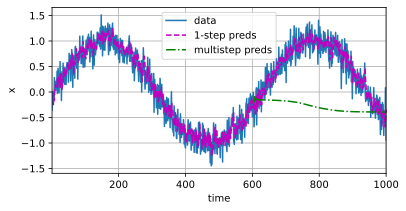

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))
# 同时画出了：
# 原始数据 x
# 单步预测 onestep_preds（训练时使用真实特征）
# 多步滚动预测 multistep_preds（后面用自己预测值继续预测）

In [10]:
max_steps = 64  # 表示我们最多预测未来 64 步

In [11]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 每一行是长度为 tau + {max_steps} 的序列
# 前 τ 项是原始观测值，后 max_steps 项是未来预测值（要填充）

# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
# 前 τ 列是原始观测

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
# 后续每列是第 i 步预测值

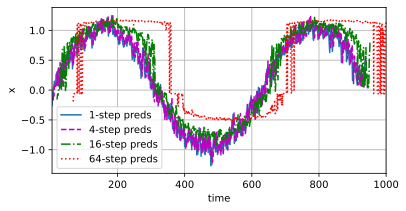

In [12]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))